In [14]:
import liwc
import pandas as pd
import numpy as np
import re
import jieba
import emoji
from collections import Counter
from bidict import bidict
import os
import sys
from scipy.stats import mannwhitneyu, ks_2samp

def parse_liwc_dict(file_path):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Not Found DICT: {file_path}")
    category_map = {}
    word_categories = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='gbk', errors='ignore') as f:
            lines = f.readlines()
    try:
        sep_index = lines.index('[#截断#]\n')
    except ValueError:
        raise ValueError("Not Found'[#截断#]'")
    header = lines[:sep_index]
    body = lines[sep_index+1:]
    for line in header:
        line = line.rstrip('\n')
        if not line.strip():
            continue
        parts = line.split()
        if len(parts) >= 2 and parts[0].isdigit():
            idx = int(parts[0])
            name = ' '.join(parts[1:])
            category_map[idx] = name
    for line in body:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        word = parts[0]
        idxs = [int(x) for x in parts[1:] if x.isdigit()]
        if idxs:
            word_categories[word] = idxs
    return category_map, word_categories

def analyze_text_categories(text, category_map, word_categories):
    counts = {}
    tokens = jieba.lcut(text)
    for tk in tokens:
        if not tk.strip():
            continue
        if tk not in word_categories:
            continue
        for idx in word_categories[tk]:
            cname = category_map.get(idx, f"unknow_{idx}")
            counts[cname] = counts.get(cname, 0) + 1
    return counts

def pad_biaoqing(text, biaoqing_list):
    pattern = re.compile("|".join(map(re.escape, biaoqing_list)))
    result = pattern.sub("EMJBQ", text)
    result = emoji.replace_emoji(result, replace="EMJBQ")
    return result

def pad_number(text):
    pattern = r'\d+[,.]?\d*'
    return re.sub(pattern, 'NUMPAD', text)

def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

def cut_word(text):
    return " ".join(list(jieba.cut(text)))

def static_describe(data):
    means = data.mean()
    stds = data.std()
    stats_df = pd.DataFrame({
        '均值': means,
        '标准差': stds,
        '均值±标准差': [f"{m:.2f}±{s:.2f}" for m, s in zip(means, stds)]
    })
    return stats_df

def get_stars(p):
    lists = []
    for i in p:
        if i < 0.001:
            lists.append('***')
        elif i < 0.01:
            lists.append('**')
        elif i < 0.05:
            lists.append('*')
        else:
            lists.append('NS')
    return lists

def k_s_stat(data1, data2):
    ks_stat, p_ks = ks_2samp(data1, data2)
    result = pd.DataFrame([ks_stat, p_ks, get_stars(p_ks)]).T
    result.columns = ['Kolmogorov-Smirnov', 'P.', 'Simple representation']
    return result


In [15]:
dic_path = 'dic/sc_liwc.dic'

with open('dic/toutiaobiaoqing.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    toutiaobiaoqing = [line.strip() for line in lines]

jieba.add_word('[666]')
jieba.add_word('NUMPAD')
jieba.add_word('EMJBQ')



#parse, category_names = liwc.load_token_parser('dic/sc_liwc.dic')
base_data = 'toutiao-based'
base_data = 'MCFEND-based'



#This part needs to request all data sets to obtain LIWC.csv
#This part needs to request all data sets to obtain LIWC.csv
#This part needs to request all data sets to obtain LIWC.csv

data = pd.read_csv('merge_22075_with_all_model.csv',dtype=str)
text = data['头条标题'][1]+'\n'+data['头条内容'][1]


In [16]:

dic_path = 'dic/sc_liwc.dic'

text = pad_biaoqing(text,toutiaobiaoqing)
text = pad_number(text)

try:
    category_map, word_categories = parse_liwc_dict(dic_path)
except Exception as e:
    print(f"Load DICT Filed：{e}", file=sys.stderr)
    sys.exit(1)

result = analyze_text_categories(text, category_map, word_categories)
bi_category_map = bidict(category_map)

for cname, freq in sorted(result.items(), key=lambda x: -x[1]):
    print(f"{cname}: {freq}")


Symbol: 4


In [17]:
counts = {}
tokens = jieba.lcut(text)
for tk in tokens:
    if not tk.strip(): #if token is【\n】
        continue
    if tk not in word_categories:
        continue
    for idx in word_categories[tk]:
        cname = category_map.get(idx, f"unknow_{idx}")
        counts[cname] = counts.get(cname, 0) + 1

In [18]:
import pandas as pd

# Biaoqing needs to be expressed in written and common expression in the manuscript, namely Emoji
columns = ['ContentID','MY_AI','MY_FK',
    'Funct', 'negate', 'quant', 'number', 'TenseM', 'PastM', 'PresentM', 'FutureM', 'ProgM', 
    'Social', 'family', 'friend', 'humans', 'Affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 
    'Cogmech', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'incl', 'excl', 'inhib', 
    'Percept', 'see', 'hear', 'feel', 'Bio', 'body', 'health', 'sexual', 'ingest', 'Relativ', 
    'motion', 'space', 'time', 'Personal Concerns', 'work', 'achievef', 'leisure', 'home', 
    'money', 'relig', 'death', 'Swear', 'Assent', 'Symbol', 'Biaoqing'
]

bold_columns_indices = [0, 9, 13, 19, 28, 32, 37, 41, 49, 50, 51, 52]

LIWC = pd.DataFrame(columns=columns)
LIWC['ContentID'] = data['ContentID']
LIWC['MY_AI'] = data['MY_AI']
LIWC['MY_FK'] = data['MY_FK']


In [19]:
for i in range(len(LIWC)):
    text = data['头条标题'][i]+'\n'+data['头条内容'][i]
    text = pad_biaoqing(text,toutiaobiaoqing)
    text = pad_number(text)

    try:
        category_map, word_categories = parse_liwc_dict(dic_path)
    except Exception as e:
        print(f"Load DICT Filed: {e}", file=sys.stderr)
        sys.exit(1)

    result = analyze_text_categories(text, category_map, word_categories)
    #bi_category_map = bidict(category_map)
    LIWC.loc[i, result.keys()] = list(result.values())
    LIWC.iloc[i] = LIWC.iloc[i].fillna(0)
    print(i)

#LIWC.to_csv(base_data+'/LIWC.csv',index=None)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27


KeyboardInterrupt



In [35]:
data = pd.read_csv('merge_22075_with_all_model.csv')
base_data = 'toutiao-based'
LIWC = pd.read_csv(base_data+'/LIWC.csv')
#LIWC['content_quality_finally'] = data['content_quality_finally'] # add quality label
#LIWC = LIWC.drop('content_quality_finally', axis=1)
#LIWC.insert(1, 'content_quality_finally', data['content_quality_finally'].tolist())
#LIWC.to_csv(base_data+'/LIWC.csv',index=None)

In [37]:
AI_FK_group = LIWC[(LIWC['content_quality_finally']=='poor')&(LIWC['MY_AI']==1)&(LIWC['MY_FK']==1)].iloc[:,4:]
AI_RL_group = LIWC[(LIWC['content_quality_finally']=='poor')&(LIWC['MY_AI']==1)&(LIWC['MY_FK']==0)].iloc[:,4:]
HM_FK_group = LIWC[(LIWC['content_quality_finally']=='poor')&(LIWC['MY_AI']==0)&(LIWC['MY_FK']==1)].iloc[:,4:]
HM_RL_group = LIWC[(LIWC['content_quality_finally']=='poor')&(LIWC['MY_AI']==0)&(LIWC['MY_FK']==0)].iloc[:,4:]

In [41]:
#ALL 


AI_FK_group = LIWC[(LIWC['MY_AI']==1)&(LIWC['MY_FK']==1)].iloc[:,4:]
AI_RL_group = LIWC[(LIWC['MY_AI']==1)&(LIWC['MY_FK']==0)].iloc[:,4:]
HM_FK_group = LIWC[(LIWC['MY_AI']==0)&(LIWC['MY_FK']==1)].iloc[:,4:]
HM_RL_group = LIWC[(LIWC['MY_AI']==0)&(LIWC['MY_FK']==0)].iloc[:,4:]


static_describe(AI_FK_group).to_excel(base_data+'/MSD_AI_FK_group.xlsx')
static_describe(AI_RL_group).to_excel(base_data+'/MSD_AI_RL_group.xlsx')
static_describe(HM_FK_group).to_excel(base_data+'/MSD_HM_FK_group.xlsx')
static_describe(HM_RL_group).to_excel(base_data+'/MSD_HM_RL_group.xlsx')



(static_describe(AI_FK_group).loc[:,['均值','标准差']]-static_describe(HM_FK_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_AIHM_FK.xlsx')
(static_describe(AI_RL_group).loc[:,['均值','标准差']]-static_describe(HM_RL_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_AIHM_RL.xlsx')


k_s_stat(AI_FK_group/len(AI_FK_group),HM_FK_group/len(HM_FK_group)).to_excel(base_data+'/ks_stats_of_AIHM_FK.xlsx',index=None)
k_s_stat(AI_RL_group/len(AI_RL_group), HM_RL_group/len(HM_RL_group)).to_excel(base_data+'/ks_stats_of_AIHM_RL.xlsx',index=None)


In [43]:
# Quality group
quality_order = ['poor', 'average', 'good']
for Q in quality_order:
    AI_FK_group = LIWC[(LIWC['content_quality_finally']==Q)&(LIWC['MY_AI']==1)&(LIWC['MY_FK']==1)].iloc[:,4:]
    AI_RL_group = LIWC[(LIWC['content_quality_finally']==Q)&(LIWC['MY_AI']==1)&(LIWC['MY_FK']==0)].iloc[:,4:]
    HM_FK_group = LIWC[(LIWC['content_quality_finally']==Q)&(LIWC['MY_AI']==0)&(LIWC['MY_FK']==1)].iloc[:,4:]
    HM_RL_group = LIWC[(LIWC['content_quality_finally']==Q)&(LIWC['MY_AI']==0)&(LIWC['MY_FK']==0)].iloc[:,4:]
    static_describe(AI_FK_group).to_excel(base_data+'/MSD_'+Q+'_AI_FK_group.xlsx')
    static_describe(AI_RL_group).to_excel(base_data+'/MSD_'+Q+'_AI_RL_group.xlsx')
    static_describe(HM_FK_group).to_excel(base_data+'/MSD_'+Q+'_HM_FK_group.xlsx')
    static_describe(HM_RL_group).to_excel(base_data+'/MSD_'+Q+'_HM_RL_group.xlsx')
    (static_describe(AI_FK_group).loc[:,['均值','标准差']]-static_describe(HM_FK_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+Q+'_AIHM_FK.xlsx')
    (static_describe(AI_RL_group).loc[:,['均值','标准差']]-static_describe(HM_RL_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+Q+'_AIHM_RL.xlsx')

    
    k_s_stat(AI_FK_group/len(AI_FK_group),HM_FK_group/len(HM_FK_group)).to_excel(base_data+'/'+Q+'_ks_stats_of_AIHM_FK.xlsx',index=None)
    k_s_stat(AI_RL_group/len(AI_RL_group), HM_RL_group/len(HM_RL_group)).to_excel(base_data+'/'+Q+'_ks_stats_of_AIHM_RL.xlsx',index=None)
    
    

In [ ]:

#This part needs to request all data sets to obtain LIWC_MCFEND_****_group.csv
#This part needs to request all data sets to obtain LIWC_MCFEND_****_group.csv
#This part needs to request all data sets to obtain LIWC_MCFEND_****_group.csv


CheapFK = pd.read_csv('mcfend_9339_Fake_for_CheapFake_Processed.csv',dtype=str)
CheapAI = pd.read_csv('mcfend_5387_real_for_CheapAI_Processed.csv',dtype=str)


In [ ]:
columns = ['news_id',
    'Funct', 'negate', 'quant', 'number', 'TenseM', 'PastM', 'PresentM', 'FutureM', 'ProgM', 
    'Social', 'family', 'friend', 'humans', 'Affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 
    'Cogmech', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'incl', 'excl', 'inhib', 
    'Percept', 'see', 'hear', 'feel', 'Bio', 'body', 'health', 'sexual', 'ingest', 'Relativ', 
    'motion', 'space', 'time', 'Personal Concerns', 'work', 'achievef', 'leisure', 'home', 
    'money', 'relig', 'death', 'Swear', 'Assent', 'Symbol', 'Biaoqing'
]
LIWC = pd.DataFrame(columns=columns)
#LIWC['news_id'] = CheapFK['news_id']
LIWC['news_id'] = CheapAI['news_id']


In [ ]:
for i in range(len(LIWC)):
    #text = str(CheapFK['title'][i])+'\n'+str(CheapFK['content'][i]) #HM FK
    #text = str(CheapFK['AIGen_title'][i])+'\n'+str(CheapFK['AIGen_content'][i]) #AI FK
    
    #text = str(CheapAI['title'][i])+'\n'+str(CheapAI['content'][i]) #HM RL
    text = str(CheapAI['AIGen_title'][i])+'\n'+str(CheapAI['AIGen_content'][i]) #AI RL

    text = pad_biaoqing(text,toutiaobiaoqing)
    text = pad_number(text)

    try:
        category_map, word_categories = parse_liwc_dict(dic_path)
    except Exception as e:
        print(f"Load DICT Filed：{e}", file=sys.stderr)
        sys.exit(1)

    result = analyze_text_categories(text, category_map, word_categories)
    #bi_category_map = bidict(category_map)
    LIWC.loc[i, result.keys()] = list(result.values())
    LIWC.iloc[i] = LIWC.iloc[i].fillna(0)
    print(i)

LIWC.to_csv(base_data+'/LIWC_MCFEND_AI_RL_group.csv',index=None)

In [ ]:
# MCFEND = pd.read_csv('MCFEND_without_length.csv')
# AI_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_AI_FK_group.csv').iloc[:,:]
# AI_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_AI_RL_group.csv').iloc[:,:]
# HM_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_FK_group.csv').iloc[:,:]
# HM_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_RL_group.csv').iloc[:,:]
# AI_FK_group.insert(1, 'gen_quality_finally', MCFEND['gen_quality_finally'][0:9339].tolist())
# AI_RL_group.insert(1, 'gen_quality_finally', MCFEND['gen_quality_finally'][9339:].tolist())
# HM_FK_group.insert(1, 'or_quality_finally', MCFEND['or_quality_finally'][0:9339].tolist())
# HM_RL_group.insert(1, 'or_quality_finally', MCFEND['or_quality_finally'][9339:].tolist())

# AI_FK_group.to_csv(base_data+'/LIWC_MCFEND_AI_FK_group.csv',index=None)
# AI_RL_group.to_csv(base_data+'/LIWC_MCFEND_AI_RL_group.csv',index=None)
# HM_FK_group.to_csv(base_data+'/LIWC_MCFEND_HM_FK_group.csv',index=None)
# HM_RL_group.to_csv(base_data+'/LIWC_MCFEND_HM_RL_group.csv',index=None)

In [ ]:
base_data = 'mcfend-based'

# AI_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_AI_FK_group.csv').iloc[:,1:]
# AI_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_AI_RL_group.csv').iloc[:,1:]
# HM_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_FK_group.csv').iloc[:,1:]
# HM_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_RL_group.csv').iloc[:,1:]


In [ ]:
quality_order = ['poor', 'average', 'good']
for Q in quality_order:
    AI_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_AI_FK_group.csv').iloc[:,1:]
    AI_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_AI_RL_group.csv').iloc[:,1:]
    HM_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_FK_group.csv').iloc[:,1:]
    HM_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_RL_group.csv').iloc[:,1:]
    
    AI_FK_group = AI_FK_group[AI_FK_group['gen_quality_finally']==Q].iloc[:,1:]
    AI_RL_group = AI_RL_group[AI_RL_group['gen_quality_finally']==Q].iloc[:,1:]
    HM_FK_group = HM_FK_group[HM_FK_group['or_quality_finally']==Q].iloc[:,1:]
    HM_RL_group = HM_RL_group[HM_RL_group['or_quality_finally']==Q].iloc[:,1:]
    
    static_describe(AI_FK_group).to_excel(base_data+'/MSD_'+Q+'_AI_FK_group.xlsx')
    static_describe(AI_RL_group).to_excel(base_data+'/MSD_'+Q+'_AI_RL_group.xlsx')
    static_describe(HM_FK_group).to_excel(base_data+'/MSD_'+Q+'_HM_FK_group.xlsx')
    static_describe(HM_RL_group).to_excel(base_data+'/MSD_'+Q+'_HM_RL_group.xlsx')
    
    #
    (static_describe(AI_FK_group).loc[:,['均值','标准差']]-static_describe(HM_FK_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+Q+'_AIHM_FK.xlsx')
    (static_describe(AI_RL_group).loc[:,['均值','标准差']]-static_describe(HM_RL_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+Q+'_AIHM_RL.xlsx')
    
    k_s_stat(AI_FK_group/len(AI_FK_group),HM_FK_group/len(HM_FK_group)).to_excel(base_data+'/'+Q+'_ks_stats_of_AIHM_FK.xlsx',index=None)
    k_s_stat(AI_RL_group/len(AI_RL_group), HM_RL_group/len(HM_RL_group)).to_excel(base_data+'/'+Q+'_ks_stats_of_AIHM_RL.xlsx',index=None)
    
    

In [24]:
# By manually sorting the code output files, Table 2 in the manuscript was obtained

# MSD_AI_FK_group.xlsx, MSD_AI_RL_group.xlsx, MSD_HM_FK_group.xlsx, MSD_HM_RL_group.xlsx
# Four files are used to calculate Diff_FK 和 Diff_RL

# ks_stats_of_AIHM_RL.xlsx,ks_stats_of_AIHM_FK.xlsx
# The two files are P.

# MCFEND also performs a similar process

# For quality_group data, do something similar. Get the documents diff_all.xlsx, diff_sd_all.xlsx, 1_toutiao_ks_test.xlsx, 1_mcfned_ks_test.xlsx

# Fig. 5.  LIWC analysis and K-S test results across quality groups. In (a), the odd and even numbers on the x-axis correspond to FK and RL, respectively. In (b), The AI-HM denotes the S.D. of AI minus that of HM. The error bars on the scatter points represent the differences in S.D. from the MCFEND. In (c), the horizontal and vertical axes represent the feature dimensions in two-tailed K-S testing and a simplified representation of p-values, respectively. NS means not significant.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36080\949234739.py:181: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=-0.72,hspace=-0.12)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36080\949234739.py:184: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("fig/LIWC_abc.eps", dpi=300)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
D:\Anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


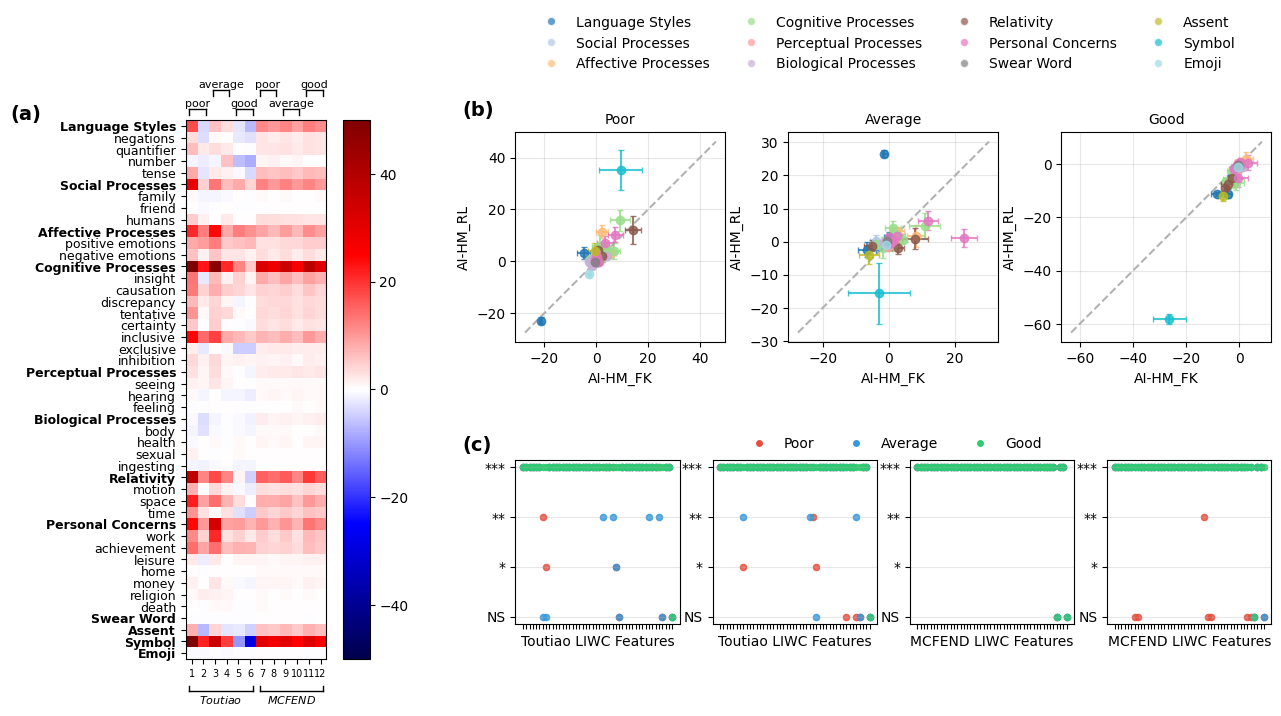

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.lines import Line2D

Dimension_se = ['Dimension', 'Language Styles', 'negations', 'quantifier', 'number', 'tense',
                'Social Processes', 'family', 'friend', 'humans', 'Affective Processes', 'positive emotions', 'negative emotions',
                'Cognitive Processes', 'insight', 'causation', 'discrepancy', 'tentative', 'certainty', 'inclusive', 'exclusive', 'inhibition',
                'Perceptual Processes', 'seeing', 'hearing', 'feeling',
                'Biological Processes', 'body', 'health', 'sexual', 'ingesting', 
                 'Relativity', 'motion', 'space', 'time', 
                'Personal Concerns', 'work', 'achievement', 'leisure', 'home', 'money', 'religion', 'death',
                'Swear Word', 'Assent', 'Symbol', 'Emoji']
custom_x_labels = ['1','2','3','4','5','6','7','8','9','10','11','12']
bold_y_labels = {'Language Styles','Social Processes','Affective Processes','Cognitive Processes','Perceptual Processes',
                 'Biological Processes','Relativity','Personal Concerns','Swear Word','Assent','Symbol','Emoji'}

dimension_groups = {
    'Language Styles': ['negations', 'quantifier', 'number', 'tense'],
    'Social Processes': ['family', 'friend', 'humans'],
    'Affective Processes': ['positive emotions', 'negative emotions'],
    'Cognitive Processes': ['insight', 'causation', 'discrepancy', 'tentative', 'certainty', 'inclusive', 'exclusive', 'inhibition'],
    'Perceptual Processes': ['seeing', 'hearing', 'feeling'],
    'Biological Processes': ['body', 'health', 'sexual', 'ingesting'],
    'Relativity': ['motion', 'space', 'time'],
    'Personal Concerns': ['work', 'achievement', 'leisure', 'home', 'money', 'religion', 'death'],
    'Swear Word':['Swear Word'],
    'Assent':['Assent'],
    'Symbol':['Symbol'],
    'Emoji':['Emoji']
    }

diff_all = pd.read_excel('diff_all.xlsx')
fig = plt.figure(figsize=(20,7), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], 
                       hspace=0.3, wspace=0.05)

ax1 = fig.add_subplot(gs[:, 0])
diff_all_se = diff_all[diff_all['Dimension'].isin(Dimension_se)].copy()
data = diff_all_se.set_index('Dimension')
heatmap_data = data.values
x_labels = data.columns.tolist()
y_labels = data.index.tolist()
cax = ax1.imshow(heatmap_data, cmap='seismic',vmin=-50,vmax=50)
fig.colorbar(cax, ax=ax1, shrink=1, anchor=(-0.25, 0.0))
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=7)
ax1.set_yticklabels(y_labels, fontsize=9)
for label in ax1.get_yticklabels():
    if label.get_text() in bold_y_labels:
        label.set_fontweight('bold')
        label.set_color('black')

def add_bracket_annotation(ax, start_idx, end_idx, label, y_offset=-0.08, bracket_height=0.01, text_p = None):
    start_x = start_idx - 0.2
    end_x = end_idx + 0.2
    center_x = (start_x + end_x) / 2
    ax.plot([start_x, start_x], [y_offset, y_offset - bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([start_x, end_x], [y_offset, y_offset], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([end_x, end_x], [y_offset, y_offset - bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.text(center_x, y_offset + bracket_height + text_p, label, 
            ha='center', va='top', fontsize=8, color='black',
            transform=ax.get_xaxis_transform(), clip_on=False)

def add_bracket_annotation2(ax, start_idx, end_idx, label, y_offset=-0.08, bracket_height=0.01):
    start_x = start_idx - 0.2
    end_x = end_idx + 0.2
    center_x = (start_x + end_x) / 2
    ax.plot([start_x, start_x], [y_offset, y_offset + bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([start_x, end_x], [y_offset, y_offset], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([end_x, end_x], [y_offset, y_offset + bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.text(center_x, y_offset + bracket_height - 0.015, label, 
            ha='center', va='top', fontsize=8, color='black',
            transform=ax.get_xaxis_transform(), clip_on=False)
    
add_bracket_annotation(ax1, 0, 1, 'poor', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 2, 3, 'average', y_offset=1.055,text_p=0.01)
add_bracket_annotation(ax1, 4, 5, 'good', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 6, 7, 'poor', y_offset=1.055,text_p=0.01)
add_bracket_annotation(ax1, 8, 9, 'average', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 10, 11, 'good', y_offset=1.055,text_p=0.01)
add_bracket_annotation2(ax1, 0, 5, '$Toutiao$', y_offset=-0.06)
add_bracket_annotation2(ax1, 6, 11, '$MCFEND$', y_offset=-0.06)
ax1.text(-1.25, 1.00, '(a)', transform=ax1.transAxes, fontsize=14, fontweight='bold')

diff_sd_all = pd.read_excel('diff_sd_all.xlsx')
ax2 = fig.add_subplot(gs[0, 1])
methods = ['poor', 'average', 'good']
colors = plt.cm.get_cmap('tab20', len(dimension_groups))
group_names = list(dimension_groups.keys())
color_map = dict(zip(group_names, colors(range(len(group_names)))))
gs_sub = gridspec.GridSpecFromSubplotSpec(1, 3, ax2, wspace=0.3)
axes_sub = [fig.add_subplot(gs_sub[0, i]) for i in range(3)]
legend_handles = []
for i, method in enumerate(methods):
    ax = axes_sub[i]
    for group_name, dimensions in dimension_groups.items():
        group_data = diff_sd_all[diff_sd_all['Dimension'].isin(dimensions)]
        if not group_data.empty:
            x_col = f'{method}-AIHM_FK'
            y_col = f'{method}-AIHM_RL'
            x_err_col = f'_{method}-AIHM_FK'
            y_err_col = f'_{method}-AIHM_RL'
            ax.set_box_aspect(1) 
            ax.errorbar(group_data[x_col], group_data[y_col],
                        xerr=abs(group_data[x_err_col]), yerr=abs(group_data[y_err_col]),
                        fmt='o', label=group_name, alpha=0.8, capsize=2,
                        color=color_map[group_name])
    ax.set_xlabel('AI-HM_FK')
    ax.set_ylabel('AI-HM_RL')
    ax.set_title(f'{method.capitalize()}', fontsize=10)
    ax.grid(True, alpha=0.3)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

for group_name in group_names:
    handle = Line2D([0], [0], marker='o', color='w', label=group_name,
                    markerfacecolor=color_map[group_name], markersize=6, alpha=0.7)
    legend_handles.append(handle)
ax2.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.49, 1.5),
           ncol=4, fontsize=10, frameon=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.text(-0.07, 1.02, '(b)', transform=ax2.transAxes, fontsize=14, fontweight='bold')

ax3 = fig.add_subplot(gs[1, 1])
df = pd.read_excel('1_toutiao_ks_test.xlsx')
df2 = pd.read_excel('1_mcfned_ks_test.xlsx')
df = df[df['Dimension'].isin(Dimension_se)].copy()
df2 = df2[df2['Dimension'].isin(Dimension_se)].copy()
sig_map = {'NS': 0, '*': 1, '**': 2, '***': 3}
for col in df.columns[1:]:
    df[col] = df[col].map(sig_map)
    df2[col] = df2[col].map(sig_map)
gs_sub2 = gridspec.GridSpecFromSubplotSpec(1, 4, ax3, wspace=0.2)
axes_sub2 = [fig.add_subplot(gs_sub2[0, i]) for i in range(4)]
colors_c = ['#E74C3C', '#3498DB', '#2ECC71']
datasets = [(df, 'FK'), (df, 'RL'), (df2, 'FK'), (df2, 'RL')]
titles = ['Toutiao-FK', 'Toutiao-RL', 'MCFEND-FK', 'MCFEND-RL']
dataset_names = ['Toutiao','Toutiao', 'MCFEND', 'MCFEND']
for idx, (data, suffix) in enumerate(datasets):
    name = dataset_names[idx]
    ax = axes_sub2[idx]
    ax.set_box_aspect(1) 
    cols = [f'{g}_{suffix}' for g in ['poor', 'average', 'good']]
    for i, col in enumerate(cols):
        ax.scatter(x=data['Dimension'], y=data[col], color=colors_c[i], s=20, alpha=0.8)
    ax.set_xlabel(f'{name} LIWC Features', fontsize=10)
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['NS', '*', '**', '***'])
    ax.grid(axis='y', alpha=0.3)
legend_elements_c = [
    Line2D([0], [0], marker='o', color='w', label='Poor', markerfacecolor='#E74C3C', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Average', markerfacecolor='#3498DB', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Good', markerfacecolor='#2ECC71', markersize=6)
]
ax3.legend(handles=legend_elements_c, loc='upper center', bbox_to_anchor=(0.5, 1.0),
           ncol=3, frameon=False, fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.text(-0.07, 0.89, '(c)', transform=ax3.transAxes, fontsize=14, fontweight='bold')

fig.subplots_adjust(wspace=-0.72,hspace=-0.12)
# plt.savefig("fig/LIWC_abc.jpg", dpi=300)
# plt.savefig("fig/LIWC_abc.svg", dpi=300)
plt.savefig("fig/LIWC_abc.eps", dpi=300)
# plt.savefig("fig/LIWC_abc.pdf", dpi=300)
plt.show(block=True)


# RQ1a supplements the LIWC code for the experiment

In [ ]:
#This part needs to request all data sets to obtain LIWC Files
#This part needs to request all data sets to obtain LIWC Files
#This part needs to request all data sets to obtain LIWCFiles

In [1]:
name_lists = [['Q_Q_【base_fake_ok】mcfend_9466_Fake_for_CheapFeak_base.csv','Q_Q_【base_real_ok】mcfend_5395_real_for_CheapAI_base.csv'],
              [ 'Q_Q_【de_fake_ok】mcfend_8794_Fake_for_CheapFeak_de.csv','Q_Q_【de_real_ok】mcfend_5255_real_for_CheapAI_de.csv'],
              [ 'Q_Q_【hb_fake_ok】mcfend_5743_Fake_for_CheapFeak_hb.csv','Q_Q_【hb_real_ok】mcfend_3440_real_for_CheapAI_hb.csv']
]

In [ ]:
for data_name in name_lists:
    print(data_name)
    if 'base' in data_name[0]:
        types = 'base'
    elif 'de' in data_name[0]:
        types = 'dev'
    elif 'hb' in data_name[0]:
        types = 'hbd'

    
    CheapFK = pd.read_csv('SUP_Gen_Q_Q/'+data_name[0],dtype=str)
    CheapAI = pd.read_csv('SUP_Gen_Q_Q/'+data_name[1],dtype=str)
    type_counts = 0
    for data in [CheapFK,CheapAI]:
        
        columns = ['news_id',
            'Funct', 'negate', 'quant', 'number', 'TenseM', 'PastM', 'PresentM', 'FutureM', 'ProgM', 
            'Social', 'family', 'friend', 'humans', 'Affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 
            'Cogmech', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'incl', 'excl', 'inhib', 
            'Percept', 'see', 'hear', 'feel', 'Bio', 'body', 'health', 'sexual', 'ingest', 'Relativ', 
            'motion', 'space', 'time', 'Personal Concerns', 'work', 'achievef', 'leisure', 'home', 
            'money', 'relig', 'death', 'Swear', 'Assent', 'Symbol', 'Biaoqing'
        ]
        LIWC = pd.DataFrame(columns=columns)

        LIWC['news_id'] = data['news_id']

        for i in range(len(LIWC)):
            #text = str(CheapFK['AIGen_title'][i])+'\n'+str(CheapFK['AIGen_content'][i]) #AI FK

            text = str(data['AIGen_title'][i])+'\n'+str(data['AIGen_content'][i]) #AI RL

            text = pad_biaoqing(text,toutiaobiaoqing)
            text = pad_number(text)

            try:
                category_map, word_categories = parse_liwc_dict(dic_path)
            except Exception as e:
                print(f"Failed to load DICT：{e}", file=sys.stderr)
                sys.exit(1)

            result = analyze_text_categories(text, category_map, word_categories)
            #bi_category_map = bidict(category_map)


            LIWC.loc[i, result.keys()] = list(result.values())

            LIWC.iloc[i] = LIWC.iloc[i].fillna(0)
            #print(i)
        
        if type_counts == 0:
            LIWC['gen_quality_finally'] = data['content_quality_finally']
            LIWC.to_csv('MCFEND_CN/LIWC_MCFEND_'+types+'_AI_FK_group.csv',index=None)
        else:
            LIWC['gen_quality_finally'] = data['content_quality_finally']
            LIWC.to_csv('MCFEND_CN/LIWC_MCFEND_'+types+'_AI_RL_group.csv',index=None)
        type_counts = type_counts +1

    

In [ ]:
#ALL 
base_data = 'MCFEND_CN/ALL'

types_lists = ['base','dev', 'hbd']
quality_order = ['poor', 'average', 'good']


for types in types_lists:
    
    for Q in quality_order:
        AI_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_'+types+'_AI_FK_group.csv').iloc[:,1:]
        AI_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_'+types+'_AI_RL_group.csv').iloc[:,1:]
        HM_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_FK_group.csv').iloc[:,1:]
        HM_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_RL_group.csv').iloc[:,1:]
        
        AI_FK_group = AI_FK_group.iloc[:,:-1]
        AI_RL_group = AI_RL_group.iloc[:,:-1]
        HM_FK_group = HM_FK_group.iloc[:,1:]
        HM_RL_group = HM_RL_group.iloc[:,1:]
        
        static_describe(AI_FK_group).to_excel(base_data+'/MSD_'+types+'_AI_FK_group.xlsx')
        static_describe(AI_RL_group).to_excel(base_data+'/MSD_'+types+'_AI_RL_group.xlsx')
        static_describe(HM_FK_group).to_excel(base_data+'/MSD_'+types+'_HM_FK_group.xlsx')
        static_describe(HM_RL_group).to_excel(base_data+'/MSD_'+types+'_HM_RL_group.xlsx')

        
        
        (static_describe(AI_FK_group).loc[:,['均值','标准差']]-static_describe(HM_FK_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+types+'_AIHM_FK.xlsx')
        (static_describe(AI_RL_group).loc[:,['均值','标准差']]-static_describe(HM_RL_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+types+'_AIHM_RL.xlsx')


        k_s_stat(AI_FK_group/len(AI_FK_group),HM_FK_group/len(HM_FK_group)).to_excel(base_data+'/0_ks_stats_of_'+types+'_AIHM_FK.xlsx',index=None)
        k_s_stat(AI_RL_group/len(AI_RL_group), HM_RL_group/len(HM_RL_group)).to_excel(base_data+'/0_ks_stats_of_'+types+'_AIHM_RL.xlsx',index=None)
        

In [ ]:
#base_data = 'MCFEND'
base_data = 'MCFEND_CN'

types_lists = ['base','dev', 'hbd']
quality_order = ['poor', 'average', 'good']


for types in types_lists:
    
    for Q in quality_order:
        AI_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_'+types+'_AI_FK_group.csv').iloc[:,1:]
        AI_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_'+types+'_AI_RL_group.csv').iloc[:,1:]
        HM_FK_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_FK_group.csv').iloc[:,1:]
        HM_RL_group = pd.read_csv(base_data+'/LIWC_MCFEND_HM_RL_group.csv').iloc[:,1:]

        AI_FK_group = AI_FK_group[AI_FK_group['gen_quality_finally']==Q].iloc[:,:-1]
        AI_RL_group = AI_RL_group[AI_RL_group['gen_quality_finally']==Q].iloc[:,:-1]
        HM_FK_group = HM_FK_group[HM_FK_group['or_quality_finally']==Q].iloc[:,1:]
        HM_RL_group = HM_RL_group[HM_RL_group['or_quality_finally']==Q].iloc[:,1:]

        static_describe(AI_FK_group).to_excel(base_data+'/MSD_'+types+'_'+Q+'_AI_FK_group.xlsx')
        static_describe(AI_RL_group).to_excel(base_data+'/MSD_'+types+'_'+Q+'_AI_RL_group.xlsx')
    #     static_describe(HM_FK_group).to_excel(base_data+'/MSD_'+types+'_'+Q+'_HM_FK_group.xlsx')
    #     static_describe(HM_RL_group).to_excel(base_data+'/MSD_'+types+'_'+Q+'_HM_RL_group.xlsx')

        (static_describe(AI_FK_group).loc[:,['均值','标准差']]-static_describe(HM_FK_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+types+'_'+Q+'_AIHM_FK.xlsx')
        (static_describe(AI_RL_group).loc[:,['均值','标准差']]-static_describe(HM_RL_group).loc[:,['均值','标准差']]).to_excel(base_data+'/diff_'+types+'_'+Q+'_AIHM_RL.xlsx')


        k_s_stat(AI_FK_group/len(AI_FK_group),HM_FK_group/len(HM_FK_group)).to_excel(base_data+'/'+Q+'_ks_stats_of_'+types+'_AIHM_FK.xlsx',index=None)
        k_s_stat(AI_RL_group/len(AI_RL_group), HM_RL_group/len(HM_RL_group)).to_excel(base_data+'/'+Q+'_ks_stats_of_'+types+'_AIHM_RL.xlsx',index=None)



In [3]:
# The steps to obtain the file for drawing the image are the same as above.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31776\803430841.py:262: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=-0.72, hspace=-0.12)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31776\803430841.py:266: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("fig/LIWC_abc_plus.eps", dpi=300)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
D:\Anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


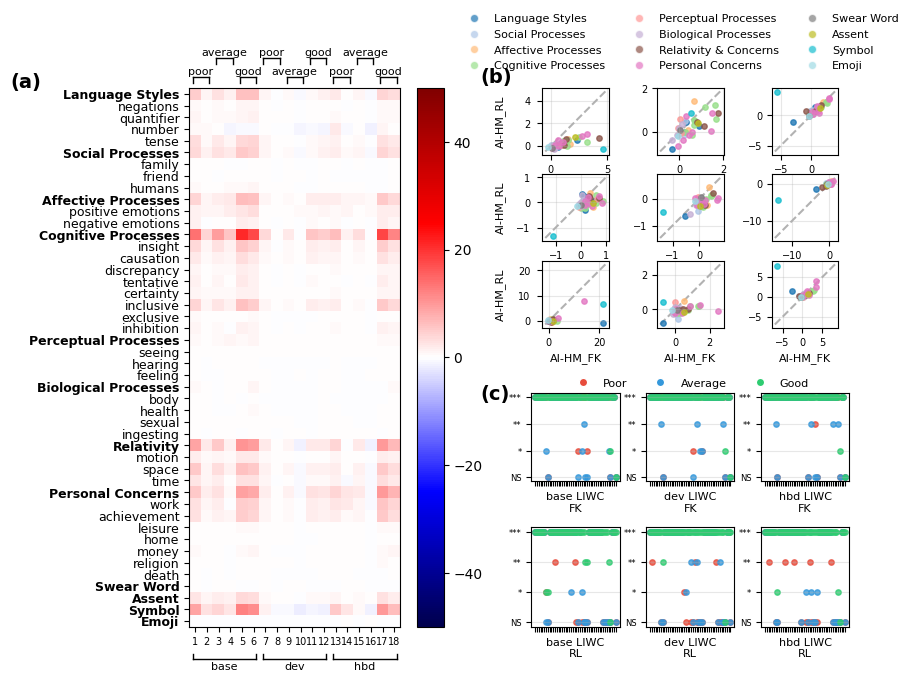

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.lines import Line2D

Dimension_se = ['Dimension', 'Language Styles', 'negations', 'quantifier', 'number', 'tense',
                'Social Processes', 'family', 'friend', 'humans', 'Affective Processes', 'positive emotions', 'negative emotions',
                'Cognitive Processes', 'insight', 'causation', 'discrepancy', 'tentative', 'certainty', 'inclusive', 'exclusive', 'inhibition',
                'Perceptual Processes', 'seeing', 'hearing', 'feeling',
                'Biological Processes', 'body', 'health', 'sexual', 'ingesting', 
                 'Relativity', 'motion', 'space', 'time', 
                'Personal Concerns', 'work', 'achievement', 'leisure', 'home', 'money', 'religion', 'death',
                'Swear Word', 'Assent', 'Symbol', 'Emoji']
custom_x_labels = [
    '1','2','3','4','5','6','7','8','9','10',
    '11','12','13','14','15','16','17','18',
]
bold_y_labels = {'Language Styles',
 'Social Processes',
'Affective Processes',
'Cognitive Processes',
'Perceptual Processes',
'Biological Processes',
 'Relativity',
'Personal Concerns',
'Swear Word', 'Assent', 'Symbol', 'Emoji'}

dimension_groups = {
    'Language Styles': ['negations', 'quantifier', 'number', 'tense'],
    'Social Processes': ['family', 'friend', 'humans'],
    'Affective Processes': ['positive emotions', 'negative emotions'],
    'Cognitive Processes': ['insight', 'causation', 'discrepancy', 'tentative', 'certainty', 'inclusive', 'exclusive', 'inhibition'],
    'Perceptual Processes': ['seeing', 'hearing', 'feeling'],
    'Biological Processes': ['body', 'health', 'sexual', 'ingesting'],
    'Relativity & Concerns': ['motion', 'space', 'time'],
    'Personal Concerns': ['work', 'achievement', 'leisure', 'home', 'money', 'religion', 'death'],
    'Swear Word': ['Swear Word'],
    'Assent': ['Assent'],
    'Symbol': ['Symbol'],
    'Emoji': ['Emoji']
}

diff_all = pd.read_excel('diff_all_SUP.xlsx')

fig = plt.figure(figsize=(14,7), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], 
                       hspace=0.25, wspace=-0.05)

ax1 = fig.add_subplot(gs[:, 0])

diff_all_se = diff_all[diff_all['Dimension'].isin(Dimension_se)].copy()
data = diff_all_se.set_index('Dimension')
heatmap_data = data.values
x_labels = data.columns.tolist()
y_labels = data.index.tolist()

cax = ax1.imshow(heatmap_data, cmap='seismic',vmin=-50,vmax=50)
fig.colorbar(cax, ax=ax1, shrink=1, anchor=(-0.25, 0.0))

ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=7)
ax1.set_yticklabels(y_labels, fontsize=9)

for label in ax1.get_yticklabels():
    if label.get_text() in bold_y_labels:
        label.set_fontweight('bold')
        label.set_color('black')

def add_bracket_annotation(ax, start_idx, end_idx, label, y_offset=-0.08, bracket_height=0.01, text_p = None):
    start_x = start_idx - 0.2
    end_x = end_idx + 0.2
    center_x = (start_x + end_x) / 2
    ax.plot([start_x, start_x], [y_offset, y_offset - bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([start_x, end_x], [y_offset, y_offset], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([end_x, end_x], [y_offset, y_offset - bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.text(center_x, y_offset + bracket_height + text_p, label, 
            ha='center', va='top', fontsize=8, color='black',
            transform=ax.get_xaxis_transform(), clip_on=False)

def add_bracket_annotation2(ax, start_idx, end_idx, label, y_offset=-0.08, bracket_height=0.01):
    start_x = start_idx - 0.2
    end_x = end_idx + 0.2
    center_x = (start_x + end_x) / 2
    ax.plot([start_x, start_x], [y_offset, y_offset + bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([start_x, end_x], [y_offset, y_offset], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.plot([end_x, end_x], [y_offset, y_offset + bracket_height], 
            color='black', linewidth=1, transform=ax.get_xaxis_transform(), clip_on=False)
    ax.text(center_x, y_offset + bracket_height - 0.015, label, 
            ha='center', va='top', fontsize=8, color='black',
            transform=ax.get_xaxis_transform(), clip_on=False)

add_bracket_annotation(ax1, 0, 1, 'poor', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 2, 3, 'average', y_offset=1.055,text_p=0.01)
add_bracket_annotation(ax1, 4, 5, 'good', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 6, 7, 'poor', y_offset=1.055,text_p=0.01)
add_bracket_annotation(ax1, 8, 9, 'average', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 10, 11, 'good', y_offset=1.055,text_p=0.01)
add_bracket_annotation(ax1, 12, 13, 'poor', y_offset=1.02,text_p=0.01)
add_bracket_annotation(ax1, 14, 15, 'average', y_offset=1.055,text_p=0.01)
add_bracket_annotation(ax1, 16, 17, 'good', y_offset=1.02,text_p=0.01)

add_bracket_annotation2(ax1, 0, 5, 'base', y_offset=-0.06)
add_bracket_annotation2(ax1, 6, 11, 'dev', y_offset=-0.06)
add_bracket_annotation2(ax1, 12, 17, 'hbd', y_offset=-0.06)

ax1.text(-0.85, 1.00, '(a)', transform=ax1.transAxes, fontsize=14, fontweight='bold')

diff_sd_all = pd.read_excel('diff_sd_all_SUP.xlsx')
ax2 = fig.add_subplot(gs[0, 1])

datasets = ['', 'dev_', 'hbd_']
dataset_names = ['base', 'dev', 'hbd']
methods = ['poor', 'average', 'good']

colors = plt.cm.get_cmap('tab20', len(dimension_groups))
group_names = list(dimension_groups.keys())
color_map = dict(zip(group_names, colors(range(len(group_names)))))

gs_sub = gridspec.GridSpecFromSubplotSpec(3, 3, ax2, wspace=0.3, hspace=0.3)
axes_sub = []
for i in range(3):
    row_axes = []
    for j in range(3):
        row_axes.append(fig.add_subplot(gs_sub[i, j]))
    axes_sub.append(row_axes)

legend_handles = []

for dataset_idx, (dataset_prefix, dataset_name) in enumerate(zip(datasets, dataset_names)):
    for method_idx, method in enumerate(methods):
        ax = axes_sub[dataset_idx][method_idx]
        ax.set_box_aspect(1)
        for group_name, dimensions in dimension_groups.items():
            group_data = diff_sd_all[diff_sd_all['Dimension'].isin(dimensions)]
            if not group_data.empty:
                x_col = f'{dataset_prefix}{method}-AIHM_FK'
                y_col = f'{dataset_prefix}{method}-AIHM_RL'
                if x_col in group_data.columns and y_col in group_data.columns:
                    ax.scatter(group_data[x_col], group_data[y_col],
                             label=group_name, alpha=0.8, s=15,
                             color=color_map[group_name])
        if dataset_idx != 2:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('AI-HM_FK', fontsize=8)
        if method_idx != 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel('AI-HM_RL', fontsize=8)
            ymin, ymax = ax.get_ylim()
            ax.yaxis.set_label_coords(-0.55, 0.5)
            ax.tick_params(axis='y', pad=10)
            ax.yaxis.set_tick_params(which='both', direction='out', pad=5)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', labelsize=7)
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()])]
        ax.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

for group_name in group_names:
    handle = Line2D([0], [0], marker='o', color='w', label=group_name,
                    markerfacecolor=color_map[group_name], markersize=6, alpha=0.7)
    legend_handles.append(handle)

ax2.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.47, 1.35),
           ncol=3, fontsize=8, frameon=False)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.text(-0.16, 1.02, '(b)', transform=ax2.transAxes, fontsize=14, fontweight='bold')

ax3 = fig.add_subplot(gs[1, 1])

df1 = pd.read_excel('1_base_ks_test.xlsx')
df2 = pd.read_excel('1_dev_ks_test.xlsx')
df3 = pd.read_excel('1_hbd_ks_test.xlsx')

df1 = df1[df1['Dimension'].isin(Dimension_se)].copy()
df2 = df2[df2['Dimension'].isin(Dimension_se)].copy()
df3 = df3[df3['Dimension'].isin(Dimension_se)].copy()

sig_map = {'NS': 0, '*': 1, '**': 2, '***': 3}
for df in [df1, df2, df3]:
    for col in df.columns[1:]:
        df[col] = df[col].map(sig_map)

gs_sub2 = gridspec.GridSpecFromSubplotSpec(2, 3, ax3, hspace=0.4, wspace=0.3)

datasets = [df1, df2, df3]
dataset_names = ['base', 'dev', 'hbd']
colors_c = ['#E74C3C', '#3498DB', '#2ECC71']

for col_idx, (data, name) in enumerate(zip(datasets, dataset_names)):
    ax = fig.add_subplot(gs_sub2[0, col_idx])
    ax.set_box_aspect(1)
    cols = ['poor_FK', 'average_FK', 'good_FK']
    for i, col in enumerate(cols):
        ax.scatter(
            x=data['Dimension'],
            y=data[col],
            color=colors_c[i],
            s=15,
            alpha=0.8
        )
    ax.set_xlabel(f'{name} LIWC\nFK', fontsize=8)
    ax.tick_params(axis='x', labelbottom=False, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xticklabels([])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['NS', '*', '**', '***'])
    ax.grid(axis='y', alpha=0.3)

for col_idx, (data, name) in enumerate(zip(datasets, dataset_names)):
    ax = fig.add_subplot(gs_sub2[1, col_idx])
    cols = ['poor_RL', 'average_RL', 'good_RL']
    for i, col in enumerate(cols):
        ax.scatter(
            x=data['Dimension'],
            y=data[col],
            color=colors_c[i],
            s=15,
            alpha=0.8
        )
    ax.set_xlabel(f'{name} LIWC\nRL', fontsize=8)
    ax.tick_params(axis='x', labelbottom=False, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xticklabels([])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['NS', '*', '**', '***'])
    ax.grid(axis='y', alpha=0.3)

legend_elements_c = [
    Line2D([0], [0], marker='o', color='w', label='Poor', markerfacecolor='#E74C3C', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Average', markerfacecolor='#3498DB', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Good', markerfacecolor='#2ECC71', markersize=6)
]

ax3.legend(handles=legend_elements_c, loc='upper center', bbox_to_anchor=(0.5, 1.08),
           ncol=3, frameon=False, fontsize=8)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax3.text(-0.16, 0.95, '(c)', transform=ax3.transAxes, fontsize=14, fontweight='bold')

fig.subplots_adjust(wspace=-0.72, hspace=-0.12)

# plt.savefig("fig/LIWC_abc_plus.jpg", dpi=300)
# plt.savefig("fig/LIWC_abc_plus.svg", dpi=300)
plt.savefig("fig/LIWC_abc_plus.eps", dpi=300)
# plt.savefig("fig/LIWC_abc_plus.pdf", dpi=300)
plt.show(block=True)
